# Imports

In [4]:
from __future__ import annotations

#import essential functions
import numpy as np
import matplotlib.pyplot as plt
from pettingzoo.atari import space_invaders_v2
import pygame
import time
import random

import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set all random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)
#for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

import os
os.environ['PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT'] = '2.0'  # set timeout to 2 seconds

# Useful classes and functions

In [2]:
from sklearn.linear_model import LogisticRegression

#define epsilon-greedy policy
def epsilon_greedy(QF, state, num_actions, epsilon):
    if np.random.uniform() < epsilon:
        # Choose a random action with probability epsilon
        return np.random.choice(num_actions)
    else:
        # Choose the action with highest Q-value for the current state
        #check if QF is a torch neural network, if so retrun the index of the max value given the state
        if isinstance(QF, torch.nn.modules.module.Module):
            return torch.argmax(QF(torch.tensor(state).float().to(device))).item()
        #else if QF is a sklearn logistic regression model, if so retrun the index of the max value given the state
        elif isinstance(QF, LogisticRegression):
            return np.argmax(QF.predict_proba([state]))
        else:
            #else return the index of the max value given the state in QF table
            return np.argmax(QF[state, :])

#define uniform random policy
def uniform_random(num_actions):
    return np.random.choice(num_actions)

#define softmax boltzmann policy
def softmax_boltzmann(Q, state, num_actions, temperature):
    # Calculate the probabilities using the softmax function
    probs = softmax(Q[state, :] / temperature)
    # Choose an action using the calculated probabilities
    return np.random.choice(num_actions, p=probs)

# Define the softmax function prevent overflow
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


## Space invaders environment

### Normal env random agent template (non-parralel, runs slower, incomplete)

In [ ]:
env = space_invaders_v2.env(render_mode="human", alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
#env = space_invaders_v2.env(render_mode="human", alternating_control=True, moving_shields=False, zigzaging_bombs=True, fast_bomb=True, invisible_invaders=True)
#env = space_invaders_v2.env(render_mode="rgb_array", alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
env.reset(seed=seed)

clock = pygame.time.Clock()

for agent in env.agent_iter():
    clock.tick(env.metadata["render_fps"]) #used to limit the fps in render mode human

    observation, reward, termination, truncation, info = env.last()
    action = env.action_space(agent).sample() #define policy or uniform_random(env.action_space(agent).n
    #break the loop if the game is over
    if termination or truncation:
        print("Game Over")
        break

    #check conditions for each reward
    #if reward is between 0 and 200 then the agent has killed an invader
    if reward > 0 and reward < 200:
        print("Agent {} has killed an invader".format(agent))
        if reward == 100:
            print("Agent {} has killed a flying saucer".format(agent))
    elif reward == 200:
        print("Agent {} has betrayed the other agent".format(agent))

    env.step(action)
    
    env.render()

#env.close() #not closing to see the final result

### Parallel env random agent template (runs faster)

In [23]:
#parallel env initialization
#parallel_env = space_invaders_v2.parallel_env(render_mode="human") #uncomment clock.tick(env.metadata["render_fps"]) in the loop to see the game
parallel_env = space_invaders_v2.parallel_env(render_mode="rgb_array")

#hyperparameters
gamma = 0.999 #discount factor
episode_count = 500


#array to store the total episode rewards for each agent
ep_rewards = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
#array to store the total discounted episode rewards for each agent
ep_rewards_d = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
#array to store the total episode steps for all agents
ep_steps = np.zeros(episode_count)
#array to store the total discounted episode steps for all agents
ep_steps_d = np.zeros(episode_count)
#array to store the total episode reward for all agents
ep_rewards_all = np.zeros(episode_count)
#array to store the total discounted episode reward for all agents
ep_rewards_d_all = np.zeros(episode_count)


for ep in tqdm(range(episode_count)):
    agent_states = parallel_env.reset()
    first_0_state, second_0_state = agent_states['first_0'], agent_states['second_0']
    assert np.array_equal(first_0_state, second_0_state) #check if the states are the same for both agents (they should be)

    terminations = {agent: False for agent in parallel_env.possible_agents}
    truncations = {agent: False for agent in parallel_env.possible_agents}

    #clock = pygame.time.Clock()
    #run while loop until the game is over for all terminations and truncations are true for all agents in the parallel env
    while not all(terminations.values()) and not all(truncations.values()):
        #clock.tick(parallel_env.metadata["render_fps"]) #used to limit the fps in render mode human

        #sample random actions for each agent or TODO define policy
        actions = {agent: parallel_env.action_space(agent).sample() for agent in parallel_env.possible_agents}
        agent_states, rewards, terminations, truncations, infos = parallel_env.step(actions)
        
        assert np.array_equal(agent_states['first_0'], agent_states['second_0']) #check if the states are the same for both agents (they should be)
        
        #print("Episode: {}".format(ep))
        #print("Agent actions: {}".format(actions))
        #print("Agent states: {}".format(agent_states))
        #print("Rewards: {}".format(rewards))
        #print("Terminations: {}".format(terminations))
        #print(truncations)
        #print(infos)
        #print("steps: {}".format(ep_steps[ep]))

        #check conditions for each reward for each agent and store the acuumulated rewards in the arrays defined above
        #if reward is between 0 and 200 then the agent has killed an invader, if reward is 100 then the agent has killed a flying saucer, if reward is 200 then the agent has betrayed the other agent, if reward is 0 then the agent has not killed anything
        for agent in parallel_env.possible_agents:
            # if rewards[agent] > 0 and rewards[agent] < 200:
            #     print("Agent {} has killed an invader".format(agent))
            #     if rewards[agent] == 100:
            #         print("Agent {} has killed a flying saucer".format(agent))
            # elif rewards[agent] == 200:
            #     print("Agent {} has betrayed the other agent".format(agent))

            ep_rewards[agent][ep] += rewards[agent]
            ep_rewards_d[agent][ep] += rewards[agent] * (gamma ** ep_steps[ep])

        ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])

        #store the number of steps in each episode
        ep_steps[ep] += 1

        #stores intrinsic motivation, based on agent's total survival time or iteration (they can both die at the same time and get 200 reward together)
        ep_steps_d[ep] += 1 * (gamma ** ep_steps[ep])
        

        #parallel_env.render() #uncomment to see the game
    
    # #print the above rewards for this episode
    # print("Episode: {}".format(ep))
    # for agent in parallel_env.possible_agents:
    #     print("Total rewards for agent {}: {}".format(agent, ep_rewards[agent][ep]))
    #     print("Total discounted rewards for agent {}: {}".format(agent, ep_rewards_d[agent][ep]))
    
    # #print the total rewards for all agents
    # print("Total rewards for all agents: {}".format(ep_rewards_all[ep]))
    # print("Total discounted rewards for all agents: {}".format(ep_rewards_d_all[ep]))
    # #print the total steps for this episode
    # print("Total steps: {}".format(ep_steps[ep]))
    # #print the total discounted steps for this episode
    # print("Total discounted steps: {}".format(ep_steps_d[ep]))
    
parallel_env.close() #comment out to see the final on-screen pygame result



100%|██████████| 500/500 [06:41<00:00,  1.25it/s]


### Calculations and plotting

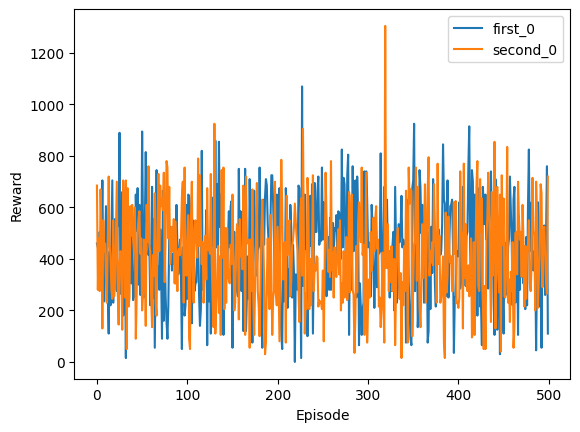

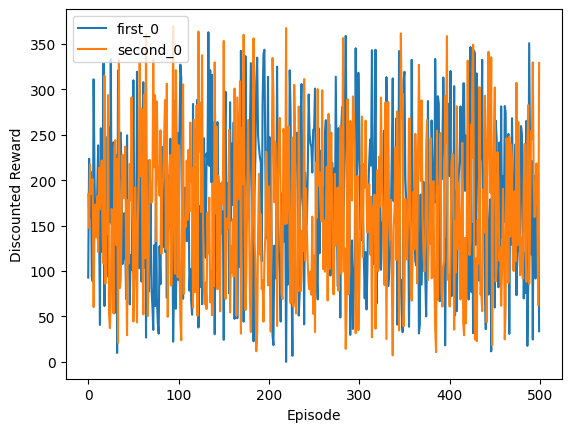

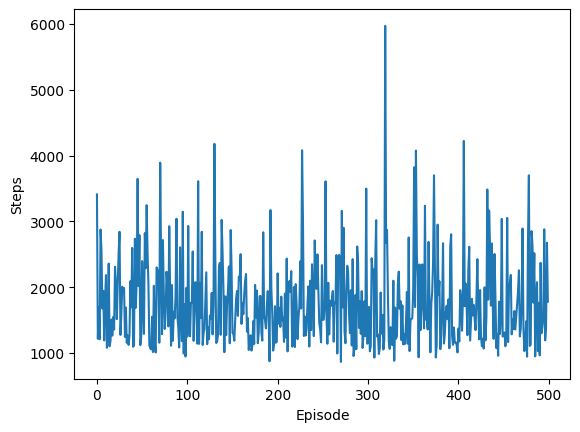

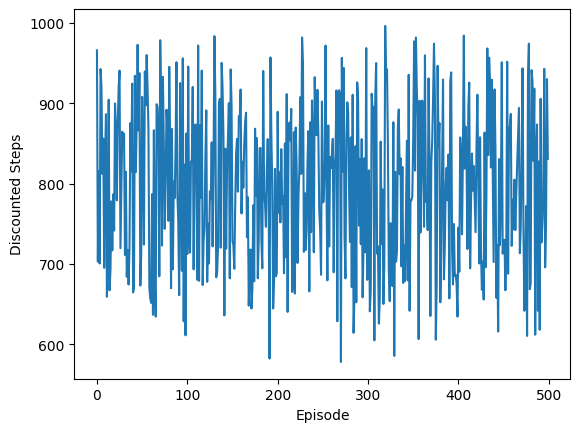

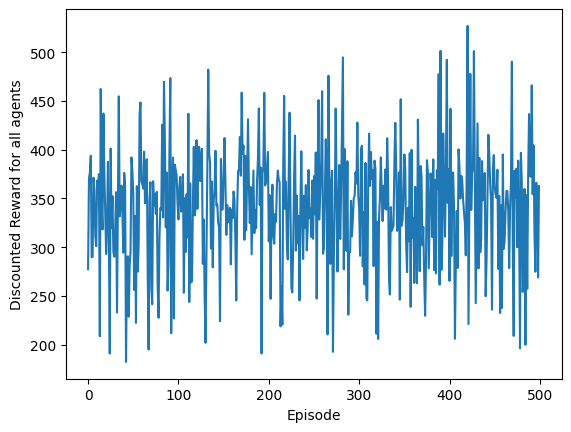

Mean rewards: {'first_0': 438.48, 'second_0': 413.17}
Variance of rewards: {'first_0': 36557.3896, 'second_0': 36562.8011}
Mean discounted rewards: {'first_0': 174.27970800913516, 'second_0': 167.00492783507127}
Variance of discounted rewards: {'first_0': 7143.413997283956, 'second_0': 7038.244336316644}
Mean steps: 1770.642
Variance of steps: 452950.869836
Mean discounted steps: 797.0881920329141
Variance of discounted steps: 9831.174193406016
Mean discounted rewards for all agents: 341.28463584420643
Variance of discounted rewards for all agents: 3602.2691766075177
Highest rewards: {'first_0': 1070.0, 'second_0': 1305.0}
Highest discounted rewards: {'first_0': 362.73061530312486, 'second_0': 369.684203539071}
Highest discounted rewards for all agents: 526.9303782640324
Highest steps: 5970.0
Highest discounted steps: 996.455923318413


In [24]:
# Calculate the mean and variance of the rewards for each agent over all episodes
mean_rewards = {agent: np.mean(ep_rewards[agent]) for agent in parallel_env.possible_agents}
var_rewards = {agent: np.var(ep_rewards[agent]) for agent in parallel_env.possible_agents}

# Calculate the mean and variance of the discounted rewards for each agent over all episodes
mean_rewards_d = {agent: np.mean(ep_rewards_d[agent]) for agent in parallel_env.possible_agents}
var_rewards_d = {agent: np.var(ep_rewards_d[agent]) for agent in parallel_env.possible_agents}

# Calculate the mean and variance of the steps for all agents over all episodes
mean_steps = np.mean(ep_steps)
var_steps = np.var(ep_steps)

# Calculate the mean and variance of the discounted steps for all agents over all episodes
mean_steps_d = np.mean(ep_steps_d)
var_steps_d = np.var(ep_steps_d)

# Calculate the mean and variance of the discounted rewards for all agents over all episodes
mean_rewards_d_all = np.mean(ep_rewards_d_all)
var_rewards_d_all = np.var(ep_rewards_d_all)

# Plot the the rewards curve for each agent over all episodes
plt.figure()
for agent in parallel_env.possible_agents:
    plt.plot(ep_rewards[agent], label=agent)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

# Plot the the discounted rewards curve for each agent over all episodes
plt.figure()
for agent in parallel_env.possible_agents:
    plt.plot(ep_rewards_d[agent], label=agent)
plt.xlabel("Episode")
plt.ylabel("Discounted Reward")
plt.legend()
plt.show()

# Plot the the steps curve for all agents over all episodes
plt.figure()
plt.plot(ep_steps)
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.show()

# Plot the the discounted steps curve for all agents over all episodes
plt.figure()
plt.plot(ep_steps_d)
plt.xlabel("Episode")
plt.ylabel("Discounted Steps")
plt.show()

# Plot the the discounted rewards curve for all agents over all episodes
plt.figure()
plt.plot(ep_rewards_d_all)
plt.xlabel("Episode")
plt.ylabel("Discounted Reward for all agents")
plt.show()

# Print the mean and variance of the rewards for each agent over all episodes
print("Mean rewards: {}".format(mean_rewards))
print("Variance of rewards: {}".format(var_rewards))
# Print the mean and variance of the discounted rewards for each agent over all episodes
print("Mean discounted rewards: {}".format(mean_rewards_d))
print("Variance of discounted rewards: {}".format(var_rewards_d))
# Print the mean and variance of the steps for all agents over all episodes
print("Mean steps: {}".format(mean_steps))
print("Variance of steps: {}".format(var_steps))
# Print the mean and variance of the discounted steps for all agents over all episodes
print("Mean discounted steps: {}".format(mean_steps_d))
print("Variance of discounted steps: {}".format(var_steps_d))
# Print the mean and variance of the discounted rewards for all agents over all episodes
print("Mean discounted rewards for all agents: {}".format(mean_rewards_d_all))
print("Variance of discounted rewards for all agents: {}".format(var_rewards_d_all))


# High scores
# Print the highest rewards for each agent over all episodes
print("Highest rewards: {}".format({agent: np.max(ep_rewards[agent]) for agent in parallel_env.possible_agents}))
# Print the highest discounted rewards for each agent over all episodes
print("Highest discounted rewards: {}".format({agent: np.max(ep_rewards_d[agent]) for agent in parallel_env.possible_agents}))
# Print the highest discounted rewards for all agents over all episodes
print("Highest discounted rewards for all agents: {}".format(np.max(ep_rewards_d_all)))
# Print the highest steps for all agents over all episodes
print("Highest steps: {}".format(np.max(ep_steps)))
# Print the highest discounted steps for all agents over all episodes
print("Highest discounted steps: {}".format(np.max(ep_steps_d)))




## PPO agent

In [12]:
#TODO

## MADDPG agent

In [ ]:
#TODO